In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from torch.utils.data import random_split
from ptoa.data.knee_monai import KneeDataset, Knee, SliceDataset
import pandas as pd
from data.knee_dataset import PixDataset
import matplotlib.pyplot as plt
import warnings
import numpy as np
import monai.transforms as MT
import torch

In [51]:
kds = KneeDataset()

outliers = [
    'patient-ccf-51566-20211014-knee_contra',
    'patient-ccf-001-20210917-knee',
]
clean_bmel = [l.strip() for l in open('/home/yua4/ptoa/ptoa/data/clean_bmel_knees.txt', 'r').readlines()]
clean_nobmel = [l.strip() for l in open('/home/yua4/ptoa/ptoa/data/clean_nobmel_knees.txt', 'r').readlines()]

df = pd.read_csv('/home/yua4/bip_submission/hakan_bmel_intra_nifti.csv', na_values='None')
df = df[df['base'] != 'comet-patient-ccf-015-20210920-knee']
hakan = df['base'].to_list()

knees = [k for k in kds.knees
             if True
            and (k.base in clean_nobmel or k.base in clean_bmel)
            # and k.base not in outliers
            # and k.base not in hakan
            # and k.path['BMELT'] is not None
            and all(k.path[x] is not None for x in ['IMG_TSE', 'DESS2TSE', 'BONE_TSE'])
        ]

In [52]:
len(knees)

184

In [50]:
len([k for k in knees if 'comet' in k.base])

40

# Check Training Data

In [42]:
kds = KneeDataset()

outliers = [
    'patient-ccf-51566-20211014-knee_contra',
    'patient-ccf-001-20210917-knee',
]
clean_bmel = [l.strip() for l in open('/home/yua4/ptoa/ptoa/data/clean_bmel_knees.txt', 'r').readlines()]
clean_nobmel = [l.strip() for l in open('/home/yua4/ptoa/ptoa/data/clean_nobmel_knees.txt', 'r').readlines()]

df = pd.read_csv('/home/yua4/bip_submission/hakan_bmel_intra_nifti.csv', na_values='None')
df = df[df['base'] != 'comet-patient-ccf-015-20210920-knee']
hakan = df['base'].to_list()

knees = [k for k in kds.knees
            if k.base in clean_nobmel
            and k.base not in outliers
            and k.base not in hakan
            and k.path['BMELT'] is None
            and all(k.path[x] is not None for x in ['IMG_TSE', 'DESS2TSE', 'BONE_TSE'])
        ]
n_train = int(len(knees) * 0.9)
n_val = len(knees) - n_train
print(len(knees), n_train, n_val)

knees_train, knees_val = random_split(knees, [n_train, n_val])
# knees_train, knees_val = knees[:20], knees[-20:]

ds_train = PixDataset(img_size=256, knees=knees_train, task='translateall')
ds_val = PixDataset(img_size=256, knees=knees_val, task='translateall')

print(f'TRN: {len(ds_train)} slices from {len(ds_train.knees)} knees')
print(f'VAL:  {len(ds_val)} slices from {len(ds_val.knees)} knees')

85 76 9


SliceDataset.tx: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.40it/s]

TRN: 1950 slices from 76 knees
VAL:  222 slices from 9 knees


In [43]:
images = list(ds_train.knees_img.values()) + list(ds_val.knees_img.values())

# images = [
#     (k['IMG_TSE'], k['DESS2TSE'], k['BONE_TSE']) for k in
#     list(ds_train.knees_img.values()) + list(ds_val.knees_img.values())
# ]
    

In [44]:
len(images)

85

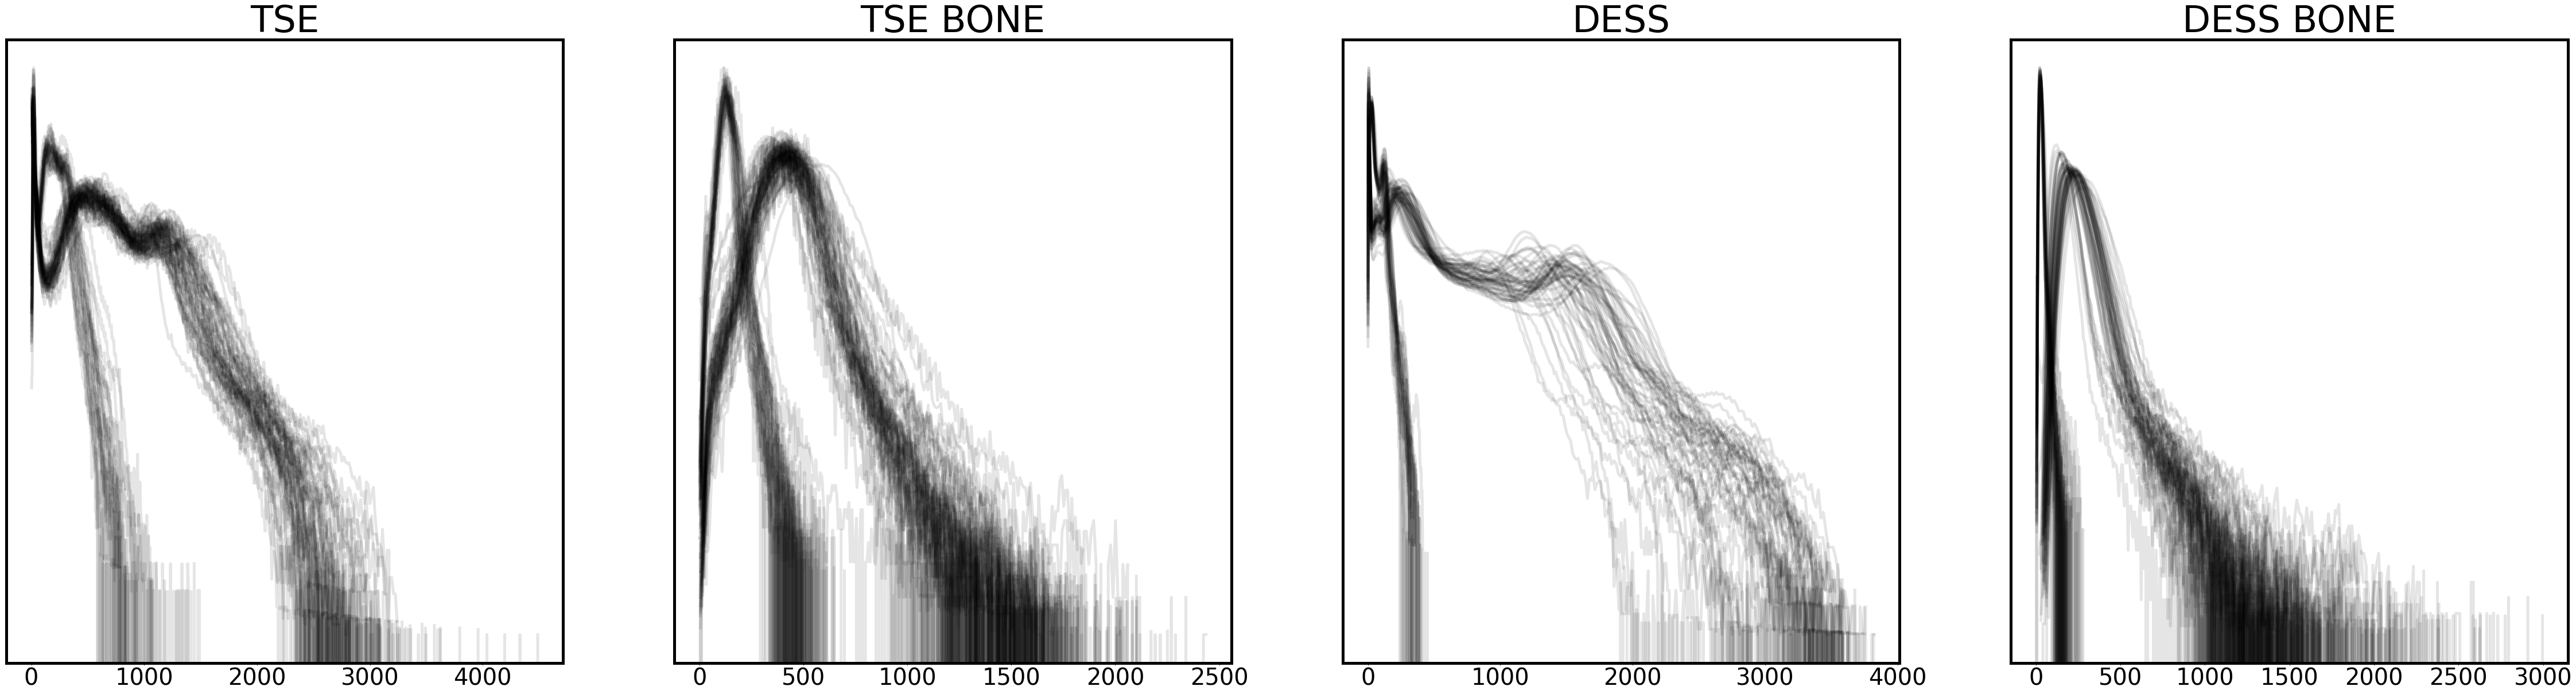

In [45]:
n_bins: int = 200
log: bool = False
alpha: float = 0.1
linewidth: float = 5.0

_, ax = plt.subplots(1, 4, figsize=(80,20))
for img in images:
    tse = img['IMG_TSE']
    dess = img['DESS2TSE']
    bone = img['BONE_TSE']
    
    data = tse
    hist, bin_edges = np.histogram(data.flatten(), n_bins, density=True)
    bins = np.diff(bin_edges) / 2 + bin_edges[:-1]
    if log:
        # catch divide by zero warnings in call to log
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            hist = np.log10(hist)
            hist[np.isinf(hist)] = 0.0
    ax[0].plot(bins, hist, alpha=alpha, linewidth=linewidth, c='k')
    ax[0].yaxis.set_visible(False)
    ax[0].set_yscale('log')
    ax[0].xaxis.set_tick_params(labelsize=40)
    ax[0].set_title('TSE', fontsize=64)
    plt.setp(ax[0].spines.values(), lw=5.0)
    
    data = tse[bone > 0.0]
    hist, bin_edges = np.histogram(data.flatten(), n_bins, density=True)
    bins = np.diff(bin_edges) / 2 + bin_edges[:-1]
    if log:
        # catch divide by zero warnings in call to log
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            hist = np.log10(hist)
            hist[np.isinf(hist)] = 0.0
    ax[1].plot(bins, hist, alpha=alpha, linewidth=linewidth, c='k')
    ax[1].yaxis.set_visible(False)
    ax[1].set_yscale('log')
    ax[1].xaxis.set_tick_params(labelsize=40)
    ax[1].set_title('TSE BONE', fontsize=64)
    plt.setp(ax[1].spines.values(), lw=5.0)
    
    data = dess
    hist, bin_edges = np.histogram(data.flatten(), n_bins, density=True)
    bins = np.diff(bin_edges) / 2 + bin_edges[:-1]
    if log:
        # catch divide by zero warnings in call to log
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            hist = np.log10(hist)
            hist[np.isinf(hist)] = 0.0
    ax[2].plot(bins, hist, alpha=alpha, linewidth=linewidth, c='k')
    ax[2].yaxis.set_visible(False)
    ax[2].set_yscale('log')
    ax[2].xaxis.set_tick_params(labelsize=40)
    ax[2].set_title('DESS', fontsize=64)
    plt.setp(ax[2].spines.values(), lw=5.0)
    
    data = dess[bone > 0.0]
    hist, bin_edges = np.histogram(data.flatten(), n_bins, density=True)
    bins = np.diff(bin_edges) / 2 + bin_edges[:-1]
    if log:
        # catch divide by zero warnings in call to log
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            hist = np.log10(hist)
            hist[np.isinf(hist)] = 0.0
    ax[3].plot(bins, hist, alpha=alpha, linewidth=linewidth, c='k')
    ax[3].yaxis.set_visible(False)
    ax[3].set_yscale('log')
    ax[3].xaxis.set_tick_params(labelsize=40)
    ax[3].set_title('DESS BONE', fontsize=64)
    plt.setp(ax[3].spines.values(), lw=5.0)
    

In [46]:
from intensity_normalization.normalize.fcm import FCMNormalize
from intensity_normalization.normalize.zscore import ZScoreNormalize
from intensity_normalization.typing import Modality, TissueType

In [47]:
fcm_norm = FCMNormalize(tissue_type=TissueType.WM)
normed = [fcm_norm(img['IMG_TSE'], img['BONE_TSE']) for img in images]

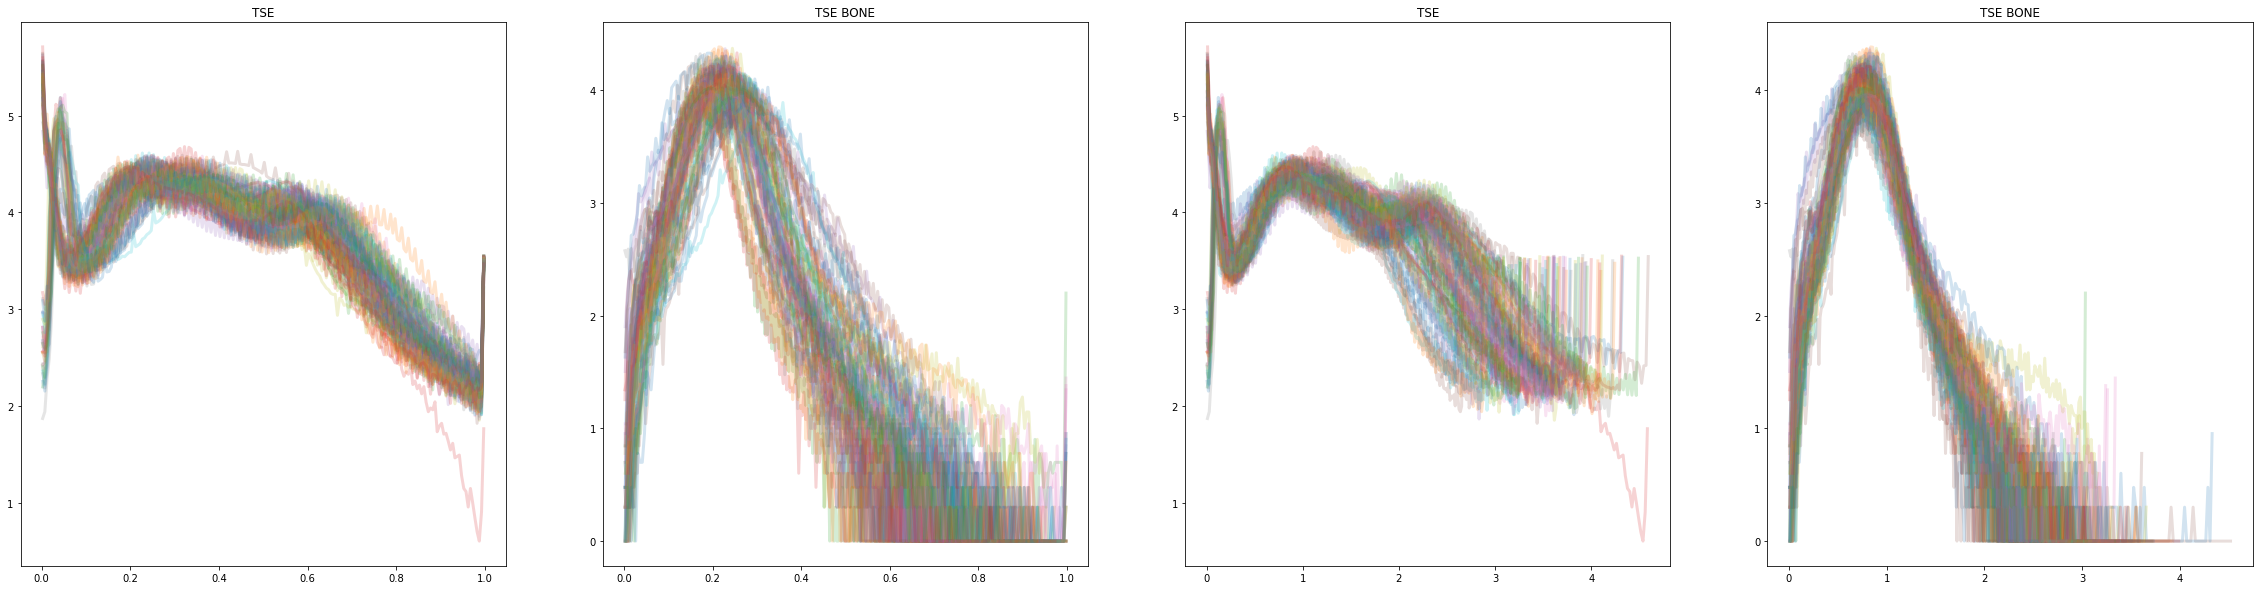

In [20]:
_, ax = plt.subplots(1, 4, figsize=(40,10))
for i, img in enumerate(images):
    tse = img['IMG_TSE']
    tse_normed = normed[i]
    bone = img['BONE_TSE']
    
    data = tse
    hist, bin_edges = np.histogram(data.flatten(), n_bins,)
    bins = np.diff(bin_edges) / 2 + bin_edges[:-1]
    if log:
        # catch divide by zero warnings in call to log
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            hist = np.log10(hist)
            hist[np.isinf(hist)] = 0.0
    ax[0].plot(bins, hist, alpha=alpha, linewidth=linewidth)
    ax[0].set_title('TSE')
    
    data = tse[bone > 0.0]
    hist, bin_edges = np.histogram(data.flatten(), n_bins,)
    bins = np.diff(bin_edges) / 2 + bin_edges[:-1]
    if log:
        # catch divide by zero warnings in call to log
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            hist = np.log10(hist)
            hist[np.isinf(hist)] = 0.0
    ax[1].plot(bins, hist, alpha=alpha, linewidth=linewidth)
    ax[1].set_title('TSE BONE')
    
    data = tse_normed
    hist, bin_edges = np.histogram(data.flatten(), n_bins,)
    bins = np.diff(bin_edges) / 2 + bin_edges[:-1]
    if log:
        # catch divide by zero warnings in call to log
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            hist = np.log10(hist)
            hist[np.isinf(hist)] = 0.0
    ax[2].plot(bins, hist, alpha=alpha, linewidth=linewidth)
    ax[2].set_title('TSE')
    
    data = tse_normed[bone > 0.0]
    hist, bin_edges = np.histogram(data.flatten(), n_bins,)
    bins = np.diff(bin_edges) / 2 + bin_edges[:-1]
    if log:
        # catch divide by zero warnings in call to log
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            hist = np.log10(hist)
            hist[np.isinf(hist)] = 0.0
    ax[3].plot(bins, hist, alpha=alpha, linewidth=linewidth)
    ax[3].set_title('TSE BONE')

In [16]:
znorm = ZScoreNormalize()
normed = [znorm(img['IMG_TSE'], img['BONE_TSE']) for img in images]

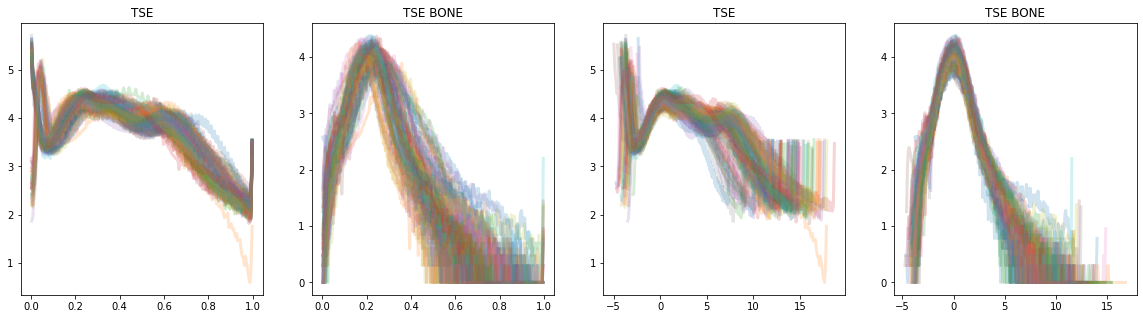

In [17]:
_, ax = plt.subplots(1, 4, figsize=(20,5))
for i, img in enumerate(images):
    tse = img['IMG_TSE']
    tse_normed = normed[i]
    bone = img['BONE_TSE']
    
    data = tse
    hist, bin_edges = np.histogram(data.flatten(), n_bins,)
    bins = np.diff(bin_edges) / 2 + bin_edges[:-1]
    if log:
        # catch divide by zero warnings in call to log
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            hist = np.log10(hist)
            hist[np.isinf(hist)] = 0.0
    ax[0].plot(bins, hist, alpha=alpha, linewidth=linewidth)
    ax[0].set_title('TSE')
    
    data = tse[bone > 0.0]
    hist, bin_edges = np.histogram(data.flatten(), n_bins,)
    bins = np.diff(bin_edges) / 2 + bin_edges[:-1]
    if log:
        # catch divide by zero warnings in call to log
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            hist = np.log10(hist)
            hist[np.isinf(hist)] = 0.0
    ax[1].plot(bins, hist, alpha=alpha, linewidth=linewidth)
    ax[1].set_title('TSE BONE')
    
    data = tse_normed
    hist, bin_edges = np.histogram(data.flatten(), n_bins,)
    bins = np.diff(bin_edges) / 2 + bin_edges[:-1]
    if log:
        # catch divide by zero warnings in call to log
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            hist = np.log10(hist)
            hist[np.isinf(hist)] = 0.0
    ax[2].plot(bins, hist, alpha=alpha, linewidth=linewidth)
    ax[2].set_title('TSE')
    
    data = tse_normed[bone > 0.0]
    hist, bin_edges = np.histogram(data.flatten(), n_bins,)
    bins = np.diff(bin_edges) / 2 + bin_edges[:-1]
    if log:
        # catch divide by zero warnings in call to log
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            hist = np.log10(hist)
            hist[np.isinf(hist)] = 0.0
    ax[3].plot(bins, hist, alpha=alpha, linewidth=linewidth)
    ax[3].set_title('TSE BONE')